In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import bambi as bmb

warnings.simplefilter(action='ignore', category=FutureWarning)

I will look at 6, 7 and 8. These all use the penguin data:

In [2]:
penguins = pd.read_csv("../code/data/penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


6. Create a model named model_p2 for the body_mass with the predictors bill_length,
bill_depth, flipper_length, and species.


In [66]:
model_p2 = bmb.Model("body_mass ~ bill_length + bill_depth  + species", data=penguins)
idata_p2 = model_p2.fit(random_seed=123,idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_length, bill_depth, species]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

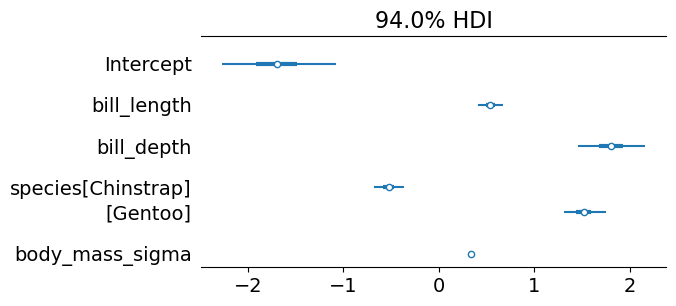

In [67]:
az.plot_forest(idata_p2, combined=True, figsize=(6, 3))



7. Use LOO to compare the model in the previous point and model_p.


In [8]:
model_p = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_p = model_p.fit(random_seed=123,idata_kwargs={'log_likelihood': True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_length, species]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [68]:
loo_p = az.loo(idata_p)
loo_p2 = az.loo(idata_p2)
az.compare({"penguins": idata_p, "penguins2": idata_p2}, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
penguins2,0,-110.277786,5.534733,0.000000,1.0,12.591478,0.000000,False,log
penguins,1,-148.963064,4.723356,38.685278,0.0,12.727290,8.520935,False,log


penguins 2 i significantly better


8. Use the functions in the interpret module to interpret model_p2. Use both plots
and tables.

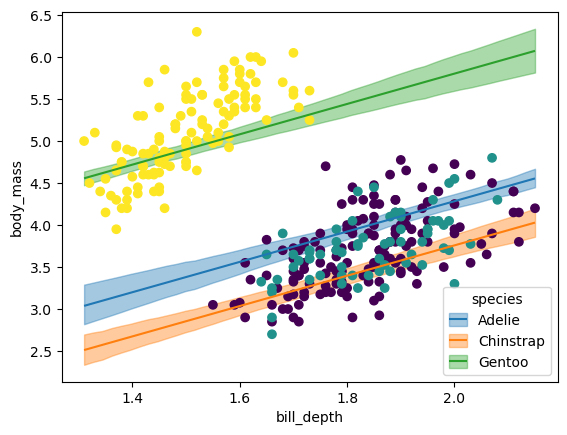

In [31]:
bmb.interpret.plot_predictions(model_p2, idata_p2, conditional=(  'bill_depth','species'))

# color points by species
 
penguins['code'] = penguins['species'].astype('category').cat.codes
plt.scatter(penguins.bill_depth, penguins.body_mass, c=penguins.code, cmap='viridis')
#plt.plot(penguins.bill_length, penguins.body_mass, 'o', color='black', alpha=0.5)

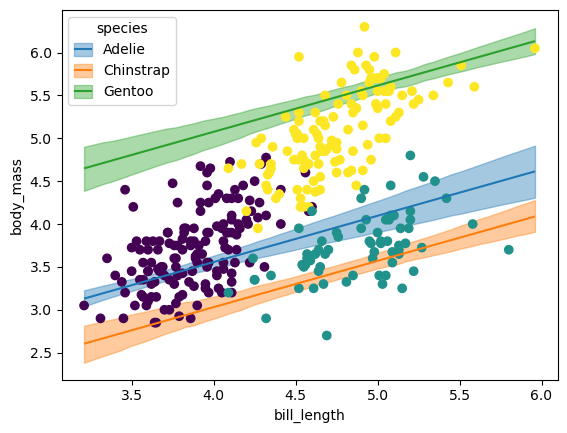

In [32]:
bmb.interpret.plot_predictions(model_p2, idata_p2, conditional=(  'bill_length','species'))

 
plt.scatter(penguins.bill_length, penguins.body_mass, c=penguins.code, cmap='viridis')

Note that the otehr parameters are held a their mean values from the data set when using "condition_by"

In [40]:
bmb.interpret.predictions(model_p2, idata_p2, 'species' )

,species,bill_depth,bill_length,estimate,lower_3.0%,upper_97.0%
0,Adelie,1.716486,4.399279,3.771905,3.660004,3.881821
1,Chinstrap,1.716486,4.399279,3.246063,3.152364,3.342342
2,Gentoo,1.716486,4.399279,5.290639,5.165407,5.410284


Average by on the other hand will average over the OTHER parameters, using the empirical distribution. 

In [39]:
bmb.interpret.predictions(model_p2, idata_p2, average_by='species')

,species,estimate,lower_3.0%,upper_97.0%
0,Adelie,3.706559,3.636673,3.776302
1,Chinstrap,3.734067,3.644926,3.821184
2,Gentoo,5.091953,5.020268,5.163460


Plot comparisions is more useful when you have non-linear links, but we can still look at comparisons here just to see how the syntax works

(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='bill_length', ylabel='body_mass'>], dtype=object))

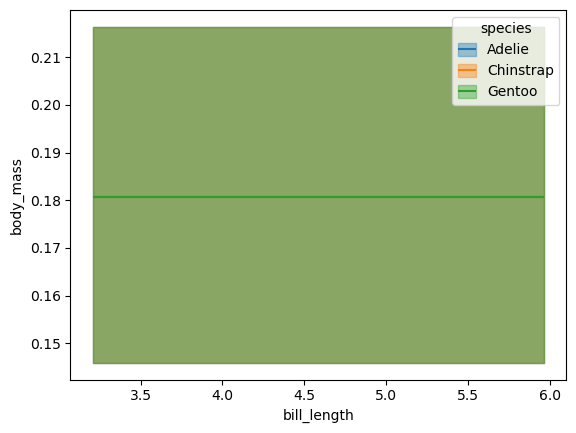

In [60]:
bmb.interpret.plot_comparisons(model_p2, idata_p2, contrast={'bill_depth': [1.5, 1.6]}, conditional = ('bill_length', 'species'))

The reason this is flat is that we don't have any interactions, the difference in the model is independnat of the other parameters.